In [1]:
from b1 import *
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
import os
import copy
import math
import statistics
import sklearn.metrics as metrics
 
# Evitar truncar data mostrada al usar jupyter notebook
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
 
# Constante que aloja el diccionario JSON con toda la data
DATA = None

# Obtener data JSON
if os.path.exists('./out/dataout.json'):
    DATA = json.load(open('./out/dataout.json', 'r'))
else:
    data_url = urlopen('http://nutriexcel.cl/UMDU/dataout_v2.json')
    DATA = json.loads(data_url.read())
 
# Labels base de las columnas
LABELS_BASE = {
    # Parámetros del alumno (Target)
    'p1':                            ['p1'],
    'p2':                            ['p2'],
    'np':                            ['np'],
    'p1p2':                          ['p1p2'], # Promedio p1p2 y p2p2
    'p2p2':                          ['p2p2'],
    
    # Parámetros del laboratorio (Features)
    'grade':                         ['g_lab#'],
    'attempts':                      ['a_lab#'],
    'usedtime':                      ['ut_lab#'],
    'activetime':                    ['act_lab#'],
    'disconnections':                ['dis_lab#'],      # log
    'compilationtime':               ['ct_lab#'],
    'runtimedebuggingtime':          ['rt_lab#'],
    'compilationtimeratio':          ['ctr_lab#'],
    'runtimedebuggingtimeratio':     ['rtr_lab#'],
    'errorsreductionratio':          ['err_lab#'],
    'compilationerrorsratio':        ['cer_lab#'],
    'activequartiles':               ['actq1_lab#','actq2_lab#','actq3_lab#'],
    'questionsdifficulty':           ['qd$_lab#'],
    'questionsgrades':               ['qg$_lab#'],      # Promedio
    'questionsattempts':             ['qat$_lab#'],     # Sumar - Max   # log
    'questionsactivetime':           ['qact$_lab#'],    # Promedio
    'questionsavgtime':              ['qavt$_lab#'],    # Promedio
    'questionsmaxerrors':            ['qme$_lab#'],     # Max
    'questionsmaxconsecutiveerrors': ['qmce$_lab#'],    # Max
    'questionsmaxsimilarityratio':   ['qmsr$_lab#'],    # Promedio
    'questionscorrectness':          ['qc$_lab#']       # Promedio
}
 
 
# Cantidad de preguntas por lab
LABS_LENGTHS = {
    '1': 7,
    '2': 6,
    '3': 6,
    '4': 5,
    '5': 3
}

In [2]:
total=0
for id in DATA["courses"]:
    students=len(DATA["courses"][id]["students"])
    total+=students
    print("curso ",id,":",students)
print("total:",total)

curso  7 : 55
curso  13 : 22
curso  19 : 54
curso  24 : 28
curso  30 : 53
curso  36 : 41
total: 253


In [3]:
#@title **Parameters**

# Objective vector
TARGET = 'mean(p$)'
NORM_TYPE = 'col'
N_FEATURES = 5
 
 
# Import needed libraries ----------------------------------------
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
 
random_state = None # Random state for train_test_split

In [4]:
# CursoData retorna el curso de los alumnos del lab Correspondiente
datalab1_all,cursoData = get_custom_dataframe(DATA, [1], ['p1','p2'], 'all', labels=True, index=None)
#@title **Data preparation**

datalab1 = copy.deepcopy(datalab1_all)

# Remove questionsdifficulty
remove_col(datalab1, 'qd?')
# Group columns
datalab1_all = apply(datalab1_all, ['p1','p2'], statistics.mean)
datalab1 = apply(datalab1, ['p1','p2'], statistics.mean)
datalab1 = apply(datalab1, 'dis_lab1', norm_log)
datalab1 = apply(datalab1, 'qg?', statistics.mean)
datalab1 = apply(datalab1, 'qat?', sum, replace=False)
datalab1 = apply(datalab1, 'sum(qat$_lab1)', norm_log, replace=False)
datalab1 = apply(datalab1, 'qat?', max)
datalab1 = apply(datalab1, 'qact?', statistics.mean)
datalab1 = apply(datalab1, 'qavt?', statistics.mean)
datalab1 = apply(datalab1, 'qme?', max)
datalab1 = apply(datalab1, 'qmce?', max)
datalab1 = apply(datalab1, 'qmsr?', statistics.mean)
datalab1 = apply(datalab1, 'qc?', statistics.mean)
aux = datalab1['act_lab1'] / datalab1['sum(qat$_lab1)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab1['avgtime_lab1'] = aux
datalab1 = datalab1.round(4)

7
13
19
24
30
36


In [5]:
# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab1 = pd.concat([datalab1,cursoDF],axis=1)


In [6]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso7 = dfFinlab1.loc[dfFinlab1['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene la columna con el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso7.reset_index()[TARGET])

# Se obtiene los datos del curso X para el lab Y normalizados Excluyendo la fila mean(p$p2)
# ------------               Función que normaliza la data      , el nombre de las col a colocar en el DF  [desde cual columna hasta cual]
DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso7),columns=dfLab1Curso7.columns)[dfLab1Curso7.columns[1:26]]
                       
datalab1Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)
datalab1Normc7

# Sentencia anterior
#datalab1Normc7 = dfLab1Curso7[['mean(p$p2)']].join(pd.DataFrame(scaler1.fit_transform(dfLab1Curso7), columns=dfLab1Curso7.columns)[dfLab1Curso7.columns[1:26]])

,mean(p$),a_lab1,ut_lab1,act_lab1,norm_log(dis_lab1),ct_lab1,rt_lab1,ctr_lab1,rtr_lab1,err_lab1,cer_lab1,actq1_lab1,actq2_lab1,actq3_lab1,max(qat$_lab1),mean(qact$_lab1),mean(qavt$_lab1),max(qme$_lab1),max(qmce$_lab1),mean(qmsr$_lab1),mean(qc$_lab1),sum(qat$_lab1),norm_log(sum(qat$_lab1)),avgtime_lab1,curso
0,3.90,0.136083,-0.455061,-0.761629,-0.123236,-0.049073,-0.890975,0.786036,-0.874950,-0.637584,0.383103,-0.514311,-0.665163,-0.709985,-0.489600,-0.852848,-0.743363,-0.148155,0.017702,0.475535,0.930445,-0.554857,-0.231774,-0.390801,0.0
1,4.15,0.136083,-0.817620,-0.125169,-0.664505,-0.603989,-0.385012,-0.690473,-0.336087,0.553319,-0.195346,-1.196970,-1.260748,-1.289504,-0.350438,-0.503732,0.468175,-0.805294,-0.523207,-0.975358,0.456763,-0.370575,-0.038347,0.348930,0.0
2,4.95,0.136083,1.016240,2.141457,1.727227,-0.647569,0.618115,-1.033409,-0.374360,1.189007,-0.304597,0.559647,0.838540,0.771844,0.275796,0.436110,0.508278,1.954690,-0.523207,-0.207310,-0.793488,0.366554,0.533396,1.668700,0.0
3,5.15,0.136083,-0.911666,-0.877879,-1.589670,-0.537167,0.542220,-0.117179,3.331465,-0.191185,-0.496710,-1.108546,-1.255053,-1.286561,-0.837508,-0.257596,1.066704,-0.673866,-0.631388,0.653245,0.519023,-0.739140,-0.459359,-0.220591,0.0
4,3.80,0.136083,-0.885970,-0.428801,0.260792,0.253080,-0.496104,0.812065,-0.275336,-0.042385,0.195740,1.020738,0.854618,0.777731,-0.350438,-0.519575,-0.314631,-0.148155,0.017702,0.578996,0.505561,-0.481144,-0.150910,0.074525,0.0
5,4.30,0.136083,-0.223061,0.834033,0.802062,1.102885,-0.547800,0.596023,-0.989770,-0.457405,0.725633,-0.137240,-0.287981,0.113180,0.484540,0.449124,0.280275,-0.148155,0.017702,-0.127584,-0.066559,0.440267,0.578680,0.190098,0.0
6,4.30,0.136083,0.525164,1.814468,1.834012,3.475076,0.554319,1.625480,-0.308141,-0.973142,2.074644,-0.264286,-0.396178,0.761379,4.311521,2.609458,0.865472,0.246129,4.344975,0.193146,0.299430,3.241359,1.662132,-0.970884,0.0
7,4.60,0.136083,0.259429,0.711943,1.007758,0.510200,-0.317917,0.142463,-0.698772,-0.682122,1.538945,-0.123689,-0.268217,-0.290390,1.528262,1.082286,-0.103934,-0.016727,2.722248,0.455451,0.113491,1.435392,1.073311,-0.787474,0.0
8,6.60,0.136083,-0.911666,-0.877879,-1.589670,-0.470344,-0.636893,0.038346,-0.051771,1.214819,-0.448682,-0.939152,-1.083546,-1.122386,-0.698345,-0.886232,-0.533004,-0.016727,-0.631388,-0.011951,0.042817,-0.849709,-0.617982,0.102401,0.0
9,5.00,0.136083,0.963889,2.519935,1.185957,-0.329437,3.794682,-0.881138,1.618888,-0.240785,0.224240,-0.280886,0.404077,0.386915,1.180355,2.582864,0.545034,1.034696,-0.090479,-0.273038,-0.788439,1.361679,1.042388,0.534182,0.0


In [7]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso13 = dfFinlab1.loc[dfFinlab1['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso13),columns=dfLab1Curso13.columns)[dfLab1Curso13.columns[1:26]]
                       
datalab1Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)


# Sentencia anterior
#datalab1Normc13 = dfLab1Curso13[['mean(p$p2)']].join(pd.DataFrame(scaler2.fit_transform(dfLab1Curso13), columns=dfLab1Curso13.columns)[dfLab1Curso13.columns[1:26]]) 

In [8]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso19 = dfFinlab1.loc[dfFinlab1['curso']=='19']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso19),columns=dfLab1Curso19.columns)[dfLab1Curso19.columns[1:26]]
                       
datalab1Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)


In [9]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso24 = dfFinlab1.loc[dfFinlab1['curso']=='24']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso24),columns=dfLab1Curso24.columns)[dfLab1Curso24.columns[1:26]]
                       
datalab1Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso30 = dfFinlab1.loc[dfFinlab1['curso']=='30']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso30),columns=dfLab1Curso30.columns)[dfLab1Curso30.columns[1:26]]
                       
datalab1Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso36 = dfFinlab1.loc[dfFinlab1['curso']=='36']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso36),columns=dfLab1Curso36.columns)[dfLab1Curso36.columns[1:26]]
                       
datalab1Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [12]:
#Se unen los datos del laboratorio 1
datalab1_norm = pd.concat([datalab1Normc7,datalab1Normc13,datalab1Normc19,datalab1Normc24,datalab1Normc30,datalab1Normc36],axis=0)
datalab1_norm = datalab1_norm.reset_index(drop = True)
#datalab1_norm

In [13]:
#LAB 2
datalab2_all,cursoData = get_custom_dataframe(DATA, [2], ['p1','p2'], 'all', labels=True, index=None)
 
datalab2 = copy.deepcopy(datalab2_all)
 
# Remove questionsdifficulty
remove_col(datalab2, 'qd?')
# Group columns
datalab2_all = apply(datalab2_all, ['p1','p2'], statistics.mean)
datalab2 = apply(datalab2, ['p1','p2'], statistics.mean)
datalab2 = apply(datalab2, 'dis_lab2', norm_log)
datalab2 = apply(datalab2, 'qg?', statistics.mean)
datalab2 = apply(datalab2, 'qat?', sum, replace=False)
datalab2 = apply(datalab2, 'sum(qat$_lab2)', norm_log, replace=False)
datalab2 = apply(datalab2, 'qat?', max)
datalab2 = apply(datalab2, 'qact?', statistics.mean)
datalab2 = apply(datalab2, 'qavt?', statistics.mean)
datalab2 = apply(datalab2, 'qme?', max)
datalab2 = apply(datalab2, 'qmce?', max)
datalab2 = apply(datalab2, 'qmsr?', statistics.mean)
datalab2 = apply(datalab2, 'qc?', statistics.mean)
aux = datalab2['act_lab2'] / datalab2['sum(qat$_lab2)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab2['avgtime_lab2'] = aux
datalab2 = datalab2.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab2 = pd.concat([datalab2,cursoDF],axis=1)

7
13
19
24
30
36


In [14]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso7 = dfFinlab2.loc[dfFinlab2['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso7),columns=dfLab2Curso7.columns)[dfLab2Curso7.columns[1:26]]
                       
datalab2Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [15]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso13 = dfFinlab2.loc[dfFinlab2['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso13),columns=dfLab2Curso13.columns)[dfLab2Curso13.columns[1:26]]
                       
datalab2Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [16]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso19 = dfFinlab2.loc[dfFinlab2['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso19),columns=dfLab2Curso19.columns)[dfLab2Curso19.columns[1:26]]
                       
datalab2Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [17]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso24 = dfFinlab2.loc[dfFinlab2['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso24),columns=dfLab2Curso24.columns)[dfLab2Curso24.columns[1:26]]
                       
datalab2Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [18]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso30 = dfFinlab2.loc[dfFinlab2['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso30),columns=dfLab2Curso30.columns)[dfLab2Curso30.columns[1:26]]
                       
datalab2Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso36 = dfFinlab2.loc[dfFinlab2['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso36),columns=dfLab2Curso36.columns)[dfLab2Curso36.columns[1:26]]
                       
datalab2Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [20]:
#Se unen los datos del laboratorio 2
datalab2_norm = pd.concat([datalab2Normc7,datalab2Normc13,datalab2Normc19,datalab2Normc24,datalab2Normc30,datalab2Normc36],axis=0)
datalab2_norm = datalab2_norm.reset_index(drop = True)
#datalab2_norm

In [21]:
#from sklearn.preprocessing import StandardScaler

#scaler1 = StandardScaler()
#datalab2Normc7 = dfLab2Curso7[['mean(p$p2)']].join(pd.DataFrame(scaler1.fit_transform(dfLab2Curso7), columns=dfLab2Curso7.columns)[dfLab2Curso7.columns[1:26]]) 
#datalab2Normc7

In [22]:
#LAB 3

datalab3_all,cursoData = get_custom_dataframe(DATA, [3], ['p1','p2'], 'all', labels=True, index=None)

datalab3 = copy.deepcopy(datalab3_all)
 
# Remove questionsdifficulty
remove_col(datalab3, 'qd?')
# Group columns
datalab3_all = apply(datalab3_all, ['p1','p2'], statistics.mean)
datalab3 = apply(datalab3, ['p1','p2'], statistics.mean)
datalab3 = apply(datalab3, 'dis_lab3', norm_log)
datalab3 = apply(datalab3, 'qg?', statistics.mean)
datalab3 = apply(datalab3, 'qat?', sum, replace=False)
datalab3 = apply(datalab3, 'sum(qat$_lab3)', norm_log, replace=False)
datalab3 = apply(datalab3, 'qat?', max)
datalab3 = apply(datalab3, 'qact?', statistics.mean)
datalab3 = apply(datalab3, 'qavt?', statistics.mean)
datalab3 = apply(datalab3, 'qme?', max)
datalab3 = apply(datalab3, 'qmce?', max)
datalab3 = apply(datalab3, 'qmsr?', statistics.mean)
datalab3 = apply(datalab3, 'qc?', statistics.mean)
aux = datalab3['act_lab3'] / datalab3['sum(qat$_lab3)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab3['avgtime_lab3'] = aux
datalab3 = datalab3.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab3 = pd.concat([datalab3,cursoDF],axis=1)



7
13
19
24
30
36


In [23]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso7 = dfFinlab3.loc[dfFinlab3['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso7),columns=dfLab3Curso7.columns)[dfLab3Curso7.columns[1:26]]
                       
datalab3Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [24]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso13 = dfFinlab3.loc[dfFinlab3['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso13),columns=dfLab3Curso13.columns)[dfLab3Curso13.columns[1:26]]
                       
datalab3Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [25]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso19 = dfFinlab3.loc[dfFinlab3['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso19),columns=dfLab3Curso19.columns)[dfLab3Curso19.columns[1:26]]
                       
datalab3Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso24 = dfFinlab3.loc[dfFinlab3['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso24),columns=dfLab3Curso24.columns)[dfLab3Curso24.columns[1:26]]
                       
datalab3Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [27]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso30 = dfFinlab3.loc[dfFinlab3['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso30),columns=dfLab3Curso30.columns)[dfLab3Curso30.columns[1:26]]
                       
datalab3Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [28]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso36 = dfFinlab3.loc[dfFinlab3['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso36),columns=dfLab3Curso36.columns)[dfLab3Curso36.columns[1:26]]
                       
datalab3Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [29]:
#Se unen los datos del laboratorio 3
datalab3_norm = pd.concat([datalab3Normc7,datalab3Normc13,datalab3Normc19,datalab3Normc24,datalab3Normc30,datalab3Normc36],axis=0)
datalab3_norm = datalab3_norm.reset_index(drop = True)
#datalab3_norm

In [30]:
#LAB 4

datalab4_all,cursoData = get_custom_dataframe(DATA, [4], ['p1','p2'], 'all', labels=True, index=None)
datalab4 = copy.deepcopy(datalab4_all)

# Remove questionsdifficulty
remove_col(datalab4, 'qd?')
# Group columns
datalab4_all = apply(datalab4_all, ['p1','p2'], statistics.mean)
datalab4 = apply(datalab4, ['p1','p2'], statistics.mean)
datalab4 = apply(datalab4, 'dis_lab4', norm_log)
datalab4 = apply(datalab4, 'qg?', statistics.mean)
datalab4 = apply(datalab4, 'qat?', sum, replace=False)
datalab4 = apply(datalab4, 'sum(qat$_lab4)', norm_log, replace=False)
datalab4 = apply(datalab4, 'qat?', max)
datalab4 = apply(datalab4, 'qact?', statistics.mean)
datalab4 = apply(datalab4, 'qavt?', statistics.mean)
datalab4 = apply(datalab4, 'qme?', max)
datalab4 = apply(datalab4, 'qmce?', max)
datalab4 = apply(datalab4, 'qmsr?', statistics.mean)
datalab4 = apply(datalab4, 'qc?', statistics.mean)
aux = datalab4['act_lab4'] / datalab4['sum(qat$_lab4)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab4['avgtime_lab4'] = aux
datalab4 = datalab4.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab4 = pd.concat([datalab4,cursoDF],axis=1)


7
13
19
24
30
36


In [31]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso7 = dfFinlab4.loc[dfFinlab4['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso7),columns=dfLab4Curso7.columns)[dfLab4Curso7.columns[1:26]]
                       
datalab4Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [32]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso13 = dfFinlab4.loc[dfFinlab4['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso13),columns=dfLab4Curso13.columns)[dfLab4Curso13.columns[1:26]]
                       
datalab4Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [33]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso19 = dfFinlab4.loc[dfFinlab4['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso19),columns=dfLab4Curso19.columns)[dfLab4Curso19.columns[1:26]]
                       
datalab4Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [34]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso24 = dfFinlab4.loc[dfFinlab4['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso24),columns=dfLab4Curso24.columns)[dfLab4Curso24.columns[1:26]]
                       
datalab4Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)


In [35]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso30 = dfFinlab4.loc[dfFinlab4['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso30),columns=dfLab4Curso30.columns)[dfLab4Curso30.columns[1:26]]
                       
datalab4Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [36]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso36 = dfFinlab4.loc[dfFinlab4['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso36),columns=dfLab4Curso36.columns)[dfLab4Curso36.columns[1:26]]
                       
datalab4Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [37]:
#Se unen los datos del laboratorio 4
datalab4_norm = pd.concat([datalab4Normc7,datalab4Normc13,datalab4Normc19,datalab4Normc24,datalab4Normc30,datalab4Normc36],axis=0)
datalab4_norm = datalab4_norm.reset_index(drop = True)

In [38]:
#@title **Grid/Random-SearchCV process**   
 
def run_process(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
    print('R2:', max(grid_cv.cv_results_['mean_test_score']))
    
    try:
        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
    except:
        return list(dataset.columns[1:])
    
    return list(selected_features)
    
def run_process_obsolete(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
 
    try:
        print('R2-test-fit:', max(grid_cv.cv_results_['mean_test_score']))
    except:
        pass

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        grid_cv.best_estimator_.fit(X_train, y_train)
        print('R2-test', grid_cv.best_estimator_.score(X_test, y_test))
        print('MSE-test', metrics.mean_squared_error(y_test,grid_cv.best_estimator_.predict(X_test)))

        print('Best params:', grid_cv.best_params_)

        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
        print('Selected features:', list(selected_features))

        return list(selected_features)
    except:
        return list(dataset.columns[1:])

In [39]:
#@title **SVR - Recursive Features Elimination**

from sklearn.svm import SVR

sel_estimator = SVR(kernel='linear')
selector = RFE(sel_estimator)
estimator = SVR()

pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])

params = {
    'sel__n_features_to_select' : [5],
    'sel__step'                 : [1,2],
    'est__C'                    : [0.01,0.1,1],
    'est__gamma'                : ['scale','auto'],
    'est__kernel'               : ['linear','poly','rbf']
}

grid_svr = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [42]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_svr_1 = run_process(datalab1_shuffle,grid_svr)
selected_features_svr_1

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   27.4s finished


R2: -0.027847394166631255


['act_lab1',
 'norm_log(dis_lab1)',
 'actq3_lab1',
 'sum(qat$_lab1)',
 'avgtime_lab1']

In [43]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_svr_2 = run_process(datalab2_shuffle,grid_svr)
selected_features_svr_2

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   28.2s finished


R2: 0.0024818705440738053


['a_lab2', 'act_lab2', 'ctr_lab2', 'mean(qact$_lab2)', 'mean(qmsr$_lab2)']

In [44]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_svr_3 = run_process(datalab3_shuffle,grid_svr)
selected_features_svr_3

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.8s finished


R2: 0.09243672203962304


['act_lab3', 'rtr_lab3', 'actq1_lab3', 'sum(qat$_lab3)', 'avgtime_lab3']

In [45]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_svr_4 = run_process(datalab4_shuffle,grid_svr)
selected_features_svr_4

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.4s finished


R2: 0.14205962118987578


['rt_lab4',
 'max(qat$_lab4)',
 'mean(qact$_lab4)',
 'mean(qavt$_lab4)',
 'norm_log(sum(qat$_lab4))']

In [46]:
estimator = SVR()

params = {
    'C'         : [0.01,0.1,1],
    'gamma'     : ['scale','auto'],
    'kernel'    : ['linear','poly','rbf']
}

grid_svr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [47]:
#Combiación lab 1 y 2
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s


R2: 0.02613049022784335


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    5.2s finished


['act_lab1',
 'norm_log(dis_lab1)',
 'actq3_lab1',
 'sum(qat$_lab1)',
 'avgtime_lab1',
 'a_lab2',
 'act_lab2',
 'ctr_lab2',
 'mean(qact$_lab2)',
 'mean(qmsr$_lab2)']

In [48]:
#Combinación lab 1, 2 y 3
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2]).join(datalab3_norm[selected_features_svr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s


R2: 0.09411965728290814


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.2s finished


['act_lab1',
 'norm_log(dis_lab1)',
 'actq3_lab1',
 'sum(qat$_lab1)',
 'avgtime_lab1',
 'a_lab2',
 'act_lab2',
 'ctr_lab2',
 'mean(qact$_lab2)',
 'mean(qmsr$_lab2)',
 'act_lab3',
 'rtr_lab3',
 'actq1_lab3',
 'sum(qat$_lab3)',
 'avgtime_lab3']

In [49]:
#Combinación lab 1, 2, 3 y 4
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2]).join(datalab3_norm[selected_features_svr_3]).join(datalab4_norm[selected_features_svr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s


R2: 0.14302263421043446


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.5s finished


['act_lab1',
 'norm_log(dis_lab1)',
 'actq3_lab1',
 'sum(qat$_lab1)',
 'avgtime_lab1',
 'a_lab2',
 'act_lab2',
 'ctr_lab2',
 'mean(qact$_lab2)',
 'mean(qmsr$_lab2)',
 'act_lab3',
 'rtr_lab3',
 'actq1_lab3',
 'sum(qat$_lab3)',
 'avgtime_lab3',
 'rt_lab4',
 'max(qat$_lab4)',
 'mean(qact$_lab4)',
 'mean(qavt$_lab4)',
 'norm_log(sum(qat$_lab4))']

In [50]:
#@title **Random Forest Regressor** 

from sklearn.ensemble import  RandomForestRegressor
 
# GradientBoostingRegressor / RandomForestRegressor / SVR(kernel='linear')
sel_estimator = GradientBoostingRegressor(random_state=1)
 
# RFE / SelectFromModel
selector = RFE(sel_estimator)
estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])
 
params = {
    'sel__estimator__learning_rate': [0.05,0.1,0.2],
    'sel__n_features_to_select'    : [5],
    'est__n_estimators'            : [50,100,200,400],
    'est__criterion'               : ['mse','mae'],
    'est__max_features'            : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [51]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_rfr_1 = run_process(datalab1_shuffle,grid_rfr)
selected_features_rfr_1

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 12.3min finished


R2: -0.12825433801322306


['ut_lab1', 'actq1_lab1', 'actq3_lab1', 'max(qat$_lab1)', 'mean(qmsr$_lab1)']

In [52]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_rfr_2 = run_process(datalab2_shuffle,grid_rfr)
selected_features_rfr_2

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 12.7min finished


R2: 0.030681338979879347


['ut_lab2', 'ctr_lab2', 'max(qat$_lab2)', 'mean(qc$_lab2)', 'avgtime_lab2']

In [53]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_rfr_3 = run_process(datalab3_shuffle,grid_rfr)
selected_features_rfr_3

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 12.0min finished


R2: 0.04908655011401486


['rtr_lab3', 'cer_lab3', 'actq1_lab3', 'max(qat$_lab3)', 'avgtime_lab3']

In [54]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_rfr_4 = run_process(datalab4_shuffle,grid_rfr)
selected_features_rfr_4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 12.3min finished


R2: 0.09488695772769623


['a_lab4', 'act_lab4', 'cer_lab4', 'mean(qc$_lab4)', 'avgtime_lab4']

In [55]:
estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
params = {
    'n_estimators'  : [50,100,200,400],
    'criterion'     : ['mse','mae'],
    'max_features'  : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [56]:
#Combinación de laboratorios
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min


R2: 0.13065170464265768


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


['ut_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'max(qat$_lab1)',
 'mean(qmsr$_lab1)',
 'ut_lab2',
 'ctr_lab2',
 'max(qat$_lab2)',
 'mean(qc$_lab2)',
 'avgtime_lab2']

In [57]:
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2]).join(datalab3_norm[selected_features_rfr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


R2: 0.16624134155579337


['ut_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'max(qat$_lab1)',
 'mean(qmsr$_lab1)',
 'ut_lab2',
 'ctr_lab2',
 'max(qat$_lab2)',
 'mean(qc$_lab2)',
 'avgtime_lab2',
 'rtr_lab3',
 'cer_lab3',
 'actq1_lab3',
 'max(qat$_lab3)',
 'avgtime_lab3']

In [58]:
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2]).join(datalab3_norm[selected_features_rfr_3]).join(datalab4_norm[selected_features_rfr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.7min finished


R2: 0.2680787959710579


['ut_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'max(qat$_lab1)',
 'mean(qmsr$_lab1)',
 'ut_lab2',
 'ctr_lab2',
 'max(qat$_lab2)',
 'mean(qc$_lab2)',
 'avgtime_lab2',
 'rtr_lab3',
 'cer_lab3',
 'actq1_lab3',
 'max(qat$_lab3)',
 'avgtime_lab3',
 'a_lab4',
 'act_lab4',
 'cer_lab4',
 'mean(qc$_lab4)',
 'avgtime_lab4']

### PLOT

In [59]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
grid_rfr.best_estimator_.fit(X_train,y_train)
ypred = grid_rfr.best_estimator_.predict(X_test)
grid_rfr.best_estimator_.score(X_test,y_test)

0.24741547457664903

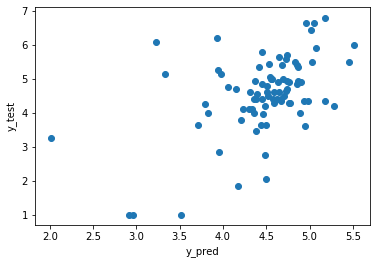

In [70]:
import matplotlib.pyplot as plt
plt.scatter(ypred,y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
#plt.show
plt.savefig('pruebas_rf_1234_0.3.png')

In [61]:
#@title **Linear Regression**

from sklearn.linear_model import LinearRegression
 
# GradientBoostingRegressor / RandomForestRegressor / SVR(kernel='linear')
sel_estimator = GradientBoostingRegressor(random_state=1)
 
# RFE / SelectFromModel
selector = RFE(sel_estimator)
estimator = LinearRegression()

pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])
 
# params = {'est__n_jobs': [-1], 
#           'est__normalize': [True], 
#           'sel__estimator__learning_rate': [0.1], 
#           'sel__estimator__n_estimators': [100], 
#           'sel__max_features': [10], 
#           'sel__prefit': [False]}

params = {
    'sel__n_features_to_select' : [5],
    'sel__step'                 : [1,2],
    'est__n_jobs'               : [-1],
}
 
grid_lr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [62]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_1 = run_process(datalab1_shuffle,grid_lr)
selected_features_lr_1

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s finished


R2: -0.016828560011491144


['ut_lab1', 'actq1_lab1', 'actq3_lab1', 'max(qat$_lab1)', 'mean(qmsr$_lab1)']

In [63]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_2 = run_process(datalab2_shuffle,grid_lr)
selected_features_lr_2

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.6s finished


R2: -0.025246618190295656


['ut_lab2', 'ctr_lab2', 'rtr_lab2', 'max(qat$_lab2)', 'avgtime_lab2']

In [64]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_3 = run_process(datalab3_shuffle,grid_lr)
selected_features_lr_3

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.5s finished


R2: 0.03700660993150094


['rtr_lab3', 'cer_lab3', 'actq1_lab3', 'max(qat$_lab3)', 'avgtime_lab3']

In [65]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_4 = run_process(datalab4_shuffle,grid_lr)
selected_features_lr_4

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.4s finished


R2: 0.060838909215779745


['ut_lab4', 'cer_lab4', 'mean(qmsr$_lab4)', 'mean(qc$_lab4)', 'avgtime_lab4']

In [66]:
estimator = LinearRegression()
 
params = {
    'n_jobs'    : [-1],
}
 
grid_lr = GridSearchCV(estimator=estimator,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [67]:
#Combinación de laboratorios 1 y 2
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.038805189651236006


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


['ut_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'max(qat$_lab1)',
 'mean(qmsr$_lab1)',
 'ut_lab2',
 'ctr_lab2',
 'rtr_lab2',
 'max(qat$_lab2)',
 'avgtime_lab2']

In [68]:
#Combinación de laboratorios 1, 2 y 3
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2]).join(datalab3_norm[selected_features_lr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.08989724090700761


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


['ut_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'max(qat$_lab1)',
 'mean(qmsr$_lab1)',
 'ut_lab2',
 'ctr_lab2',
 'rtr_lab2',
 'max(qat$_lab2)',
 'avgtime_lab2',
 'rtr_lab3',
 'cer_lab3',
 'actq1_lab3',
 'max(qat$_lab3)',
 'avgtime_lab3']

In [69]:
#Combinación de laboratorios 1, 2, 3 y 4
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2]).join(datalab3_norm[selected_features_lr_3]).join(datalab4_norm[selected_features_lr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.13966032680714527


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


['ut_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'max(qat$_lab1)',
 'mean(qmsr$_lab1)',
 'ut_lab2',
 'ctr_lab2',
 'rtr_lab2',
 'max(qat$_lab2)',
 'avgtime_lab2',
 'rtr_lab3',
 'cer_lab3',
 'actq1_lab3',
 'max(qat$_lab3)',
 'avgtime_lab3',
 'ut_lab4',
 'cer_lab4',
 'mean(qmsr$_lab4)',
 'mean(qc$_lab4)',
 'avgtime_lab4']